# **전이학습**

## **구현 초기 설정**

In [3]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

!git clone https://github.com/Rope-player/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 548 (delta 5), reused 162 (delta 0), pack-reused 374
Receiving objects: 100% (548/548), 50.13 MiB | 38.34 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [4]:
%cd "pytorch_advanced"

/content/pytorch_advanced


In [5]:
%cd "1_image_classification"

/content/pytorch_advanced/1_image_classification


In [6]:
%ls

1-1_load_vgg.ipynb
1-1_load_vgg_on_GoogleColab.ipynb
1-3_transfer_learning.ipynb
1_3_transfer_learning_on_GoogleColab.ipynb
1-5_fine_tuning.ipynb
data/
make_folders_and_data_downloads.ipynb
utils/


## **데이터셋 작성**

- **ImageTransform :** 화상의 전처리 클래스
- **make_datapath_list :** 화상의 파일경로를 리스트형 변수에 저장하는 함수
- **HymenopteraDataset :** 전처리 클래스와 함수를 사용한 Dataset 클래스

In [7]:
class ImageTransform():

# 화상 전처리 클래스, 훈련 시와 검증 시의 동작이 다름.
# 화상 크기를 리사이즈 하고 색상을 표준화한다.
# 훈련시에는 RandomResizeCrop과 RandomHorizontalFlip으로 데이터를 확장.

# reisize: int  
#   크기 변경 전의 화상 크기
# mean : (R, G, B)
#   각 색상 채널의 평균값
# std : (R, G, B)
#   각 색상 채널의 표준편차

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(      
                    resize, scale = (0.5, 1.0)),  # 화상을 0.5 ~ 1.0 으로 랜덤하게 확대 및 축소
                transforms.RandomHorizontalFlip(),# 이미지를 랜덤하게(50%) 수평으로 반전시킨다.
                transforms.ToTensor(),            # 이미지 데이터를 tensor로 바꿔준다.
                transforms.Normalize(mean, std)   # 표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),    # 사진의 중앙을 오려내는 함수, 한 변이 (resize)크기인 정사각형 으로 자름.
                transforms.ToTensor(),            # 이미지 데이터를 tensor로 바꿔준다.
                transforms.Normalize(mean, std)   # 표준화
            ]) 
       }

    def __call__(self, img, phase = 'train'):
        return self.data_transform[phase](img)

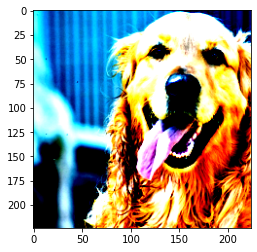

In [11]:
image_flie_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_flie_path)

# 원본 화상(사진) 표시
plt.imshow(img)
plt.show

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase = "train")

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0 ~ 1로 값을 제한해 표시.
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)

# 실행할 때마다 결과가 다름.
plt.imshow(img_transformed)
plt.show()

파일 경로 문자열을 osp.json으로 작성하고 glob으로 파일 경로를 가져오기.

In [9]:
# 개미와 벌이 담긴 화상 파일의 경로 리스트 작성

def make_datapath_list(phase = "train"):

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath + phase + '/**/*.jpg')  # rootpath 밑의 phase(train 이거나 val) 밑의 모든 폴더 모든 파일(?) 지정
    print(target_path)

    path_list = [] # 이곳에 데이터 경로 저장

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 실행
train_list = make_datapath_list(phase = "train")
val_list = make_datapath_list(phase = "val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/469333327_358ba8fe8a.jpg',
 './data/hymenoptera_data/train/bees/452462677_7be43af8ff.jpg',
 './data/hymenoptera_data/train/bees/16838648_415acd9e3f.jpg',
 './data/hymenoptera_data/train/bees/132511197_0b86ad0fff.jpg',
 './data/hymenoptera_data/train/bees/154600396_53e1252e52.jpg',
 './data/hymenoptera_data/train/bees/478701318_bbd5e557b8.jpg',
 './data/hymenoptera_data/train/bees/2528444139_fa728b0f5b.jpg',
 './data/hymenoptera_data/train/bees/522104315_5d3cb2758e.jpg',
 './data/hymenoptera_data/train/bees/150013791_969d9a968b.jpg',
 './data/hymenoptera_data/train/bees/465133211_80e0c27f60.jpg',
 './data/hymenoptera_data/train/bees/509247772_2db2d01374.jpg',
 './data/hymenoptera_data/train/bees/2053200300_8911ef438a.jpg',
 './data/hymenoptera_data/train/bees/2683605182_9d2a0c66cf.jpg',
 './data/hymenoptera_data/train/bees/205835650_e6f2614bee.jpg',
 './data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg',
 './data/hymenoptera_data/train/bees/2

이제 `Dataset` 클래스를 작성하여 훈련 데이터와 검증 데이터에 각각의 인스턴스를 만들기.

화상이 개미라면 `label`을 0으로, 벌이라면 1로.

Dataset을 만들때 Dataset에서 하나의 게이터를 꺼내는 메소드인 `__getitem__()`과 Dataset의 파일 수를 반환하는 `__len__`메소드를 구현.

In [12]:
# 개미와 벌이 담긴 화상 파일 경로의 리스트 작성

class HymenopteraDataset(data.Dataset):

  def __init__(self, file_list, transform = None, phase = 'train'):   # phase : 훈련 데이터인지 검증 데이터인지 지정
        self.file_list = file_list    # 파일 경로 리스트
        self.transform = transform    # 전처리 클래스 인스턴스
        self.phase = phase            # train or val 지정

  def __len__(self):
        return len(self.file_list)    # 화상의 개수 반환

  def __getitem__(self, index):       # 전처리한 화상의 텐서 형식 데이터와 라벨을 구하는 부분.

        # index번째의 화상 불러오기
        img_path = self.file_list[index]
        img = Image.open(img_path)

        # 화상의 전처리 실시
        img_transformed = self.transform(
            img, self.phase) 

        # 화상 파일을 파일 이름에서 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # 라벨을 숫자로 변환
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label

#실행

train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')


# 동작 확인

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


## **데이터로더 작성**

데이터로더는 `torch.utils.data.DataLoader` 클래스를 그대로 사용

훈련용 데이터로더는 `shuffle = True`로 설정, 화상을 꺼내는 순서는 랜덤으로 함.

훈련용 및 검증용 데이터로더를 작성하고 양자를 사전형 변수 `datalaoders_dict`에 저장. (사전형 변수에 넣으면 학습 및 검증시 다루기 용이함.)

In [14]:
# 미니 배치 크기 지정
batch_size = 32

# 데이터로더 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)   # 훈련용은 shuffle을 True로 함.

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle = False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1])


## **네트워크 모델 작성**

1.1절을 참고하여 학습된 VGG-16모델을 가져옴.

In [15]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# VGG-16의 마지막 출력층의 출력 유닛을 개미와 벌 두 개로 지정
net.classifier[6] = nn.Linear(in_features = 4096, out_features = 2)

# 훈련모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


## **손실함수 정의**

In [16]:
criterion = nn.CrossEntropyLoss()

## **최적화 기법 설정**

전이학습으로 학습하고 변화시킬 파라미터 설정.

네트워크 모델의 파라미터에 대해 `requires_grad = True`로 설정한 파라미터는 오차 역전파로 경사를 계산하여 학습 시에 값이 변함. (파라미터를 갱신하지 않으려면 `False`로 설정) 

In [17]:
# 학습시킬 파라미터를 params_to_update에 저장
params_to_update = []

# 학습할 파라미터의 이름
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 외에는 requires_grad = False로 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# 내용 확인
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0068,  0.0091,  0.0105,  ..., -0.0012,  0.0129, -0.0029],
        [-0.0141, -0.0116, -0.0075,  ...,  0.0135,  0.0111, -0.0149]],
       requires_grad=True), Parameter containing:
tensor([-7.4200e-03,  6.7059e-05], requires_grad=True)]


In [20]:
optimizer = optim.SGD(params = params_to_update, lr = 0.001, momentum = 0.9)

## **학습 및 검증 실시**

모델을 훈련시키는 `train_model` 함수 정의. 학습과 검증을 에폭(`epoch`)마다 교대로 실시, 학습 시에는 net을 훈련 모드로, 검증 시에는 검증 모드로 전환

`with torch.set_grad_enabled(phase == 'train'):` 은 학습 시에만 경사를 계사하는 설정.

In [21]:
# 모델을 학습시키는 함수

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epoch의 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 학습, 검증 루트
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 훈련 모드
            else:
                net.eval()   # 검증 모드

            epoch_loss = 0.0  # epoch 손실 합
            epoch_corrects = 0  # epoch 정답 수

            # 학습하지 않을 때 검증 성능 확인을 위해 epoch = 0의 훈련은 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로도로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # 옵티마이저 초기화
                optimizer.zero_grad()

                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실 계산
                    _, preds = torch.max(outputs, 1)  # 라벨(정답) 예측
                    
  
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 반복 결과 계산
                    # 손실 합계 계산
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 정답 수 합계 계산
                    epoch_corrects += torch.sum(preds == labels.data)

            # 에폭당 정답률과 손실 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

train_model 함수 실행. 

1에폭만 학습해봄.

In [22]:
num_epoch = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epoch)

Epoch 1/2
-------------


100%|██████████| 5/5 [01:26<00:00, 17.26s/it]


val Loss: 0.8871 Acc: 0.2614
Epoch 2/2
-------------


100%|██████████| 8/8 [02:16<00:00, 17.04s/it]


train Loss: 0.5879 Acc: 0.6626


100%|██████████| 5/5 [01:25<00:00, 17.06s/it]

val Loss: 0.1761 Acc: 0.9673
